# Optimization and Image Processing Project 1

## Project Description
In this project you are going to derive an image processing approach to statistical analysis on
microscopy images showing so-called (regular) heptamer arrangements (“clusters”) of gold(Au)
nano-particles on a substrate. 

The project goal is to answer relevant statistical morphology
questions automatically. All questions below should be answered in for of a histogram,
displaying the quantity on question over the (reasonably binned) number of particles/clusters
fulfilling this quantity.

<h2><center> Reference image</center></h2>

<img src="../images/heptamers.png" width=500, title="Reference image">


## Tasks

The target tasks to be performed are:
Use (and extend) you image processing library to automatically measure:

1. The diameter of all single particles shown on the provided microscopy images.
2. The number of particles per heptamer cluster (ideally 7).
3. (VOLUNTARY): for the regular clusters (7 particles): their orientation, i.e., the angle about which they are turned relative to one reference orientation.

# Overview of Process

## Flowchart of Process

<h2><center>Process Flowchart</center></h2>

<img src="../images/Process_Diagram.png" width=250, title="Process Flowchart">

The steps taken to complete the tasks are as follows:

### 1. Load and crop image
    1. Load the image into Python
    2. Split the image into the legend and the clusters
    3. Save images to disk/cache
    
<h3><center>Load and Crop Image</center></h3>

<img src="../images/1.png" width=150, title="Load and Crop Image">
    
### 2. Find the pixel size relative to the real world
For this step, we use the legend image we created in step 1.
    1. Use a line scan to get the first and last pixel of the scale
    2. Find the length using the first and last pixel
    3. Given that we know the size of the scale (4 micrometers), we calculate the size of a single pixel
    
<h3><center>Finding the Pixel Size Relative to Real World</center></h3>

<img src="../images/2.png" width=150, title="Finding the Pixel Size Relative to Real World">
    
### 3. Segment the image into clusters
For this step, we use the cluster image we created in step 1.
    1. Convert the image to binary (using thresholding)
    2. Dilate the image using convolution
    3. Label regions within the image using flood fill
    4. Get the boundary boxes for region
    5. Using the boundary boxes, divide the image into clusters
    
<h3><center>Segment Image Into Clusters</center></h3>

<img src="../images/3.png" width=150, title="Segment Image Into Clusters">
    
### 4. Find the number of beads in each cluster
For this step, we use the cluster images from step 3. The steps are performed for each cluster.
    1. Scale image to increase resolution
    2. Erode image to amplify features
    3. Create distance map for watershedding
    4. Perform the watershed algorithm
    5. Count the number of labels in cluster

After these steps are performed for every cluster, the values are used to create a histogram of number of beads per cluster.

<h3><center>Find the Number of Beads In Each Cluster</center></h3>

<img src="../images/4.png" width=500, title="Find the Number of Beads In Each Cluster">

### 5. Find the size of each bead in each cluster
For this step, we use the cluster images from step 3. The steps are performed for each cluster.

    1. Scale image to increase resolution
    2. Erode image to amplify features
    3. Create distance map for watershedding
    4. Perform the watershed algorithm
    5. Using the area of each label, approximate a circle with the same area.
    6. Dilate circles to compensate for the erosion in step 5.2.
    7. Find area of dilated circles
    8. Use dilated areas to approximate new circles
    9. Find the diameters of these circles
    10. Convert the diameters from pixels to real world size using the value found in step 2.

After these steps are performed, the values are used to create a histogram of number of beads per cluster.

<h3><center>Find the Size of Each Bead In Each Cluster</center></h3>

<img src="../images/5.png" width=500, title="Find the Size of Each Bead In Each Cluster">

# Demonstration

### 1. Load and crop image
    1. Load the image into Python


In [1]:
import modules.oiplib as oiplib

originalImage = oiplib.loadImage("../images/heptamers.tiff")
oiplib.showImage(originalImage, figsize=(10,10), title="Original Image")

(<Figure size 1000x1000 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d328850>)

2. Split the image into the legend and the clusters

In [2]:
cropped, legend = oiplib.separateLegend(originalImage)

Now we have two images, one of the clusters alone and one of the legend.
We save these images for later use.

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d9d7d50>)

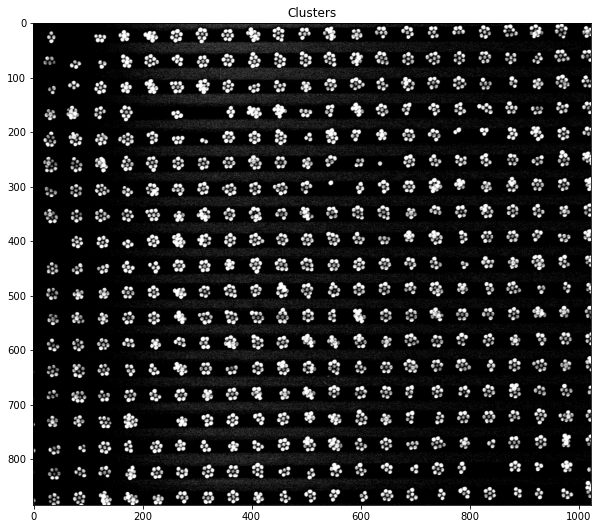

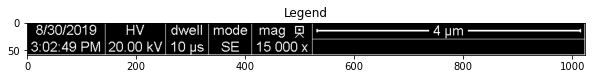

In [3]:
oiplib.showImage(cropped, figsize=(10,10), title="Clusters")
oiplib.showImage(legend, figsize=(10,10), title="Legend")

### 2. Find the pixel size relative to the real world
For this step, we use the legend image we created in step 1. Since the legend is generated by the microscope, we know the anchorpoint and value of the scale as these are constant. They are coordinates (514, 15) and 4 micrometers.
    1. Use a line scan to get the first and last pixel of the scale
    2. Find the length using the first and last pixel
    3. Given that we know the size of the scale (4 micrometers), we calculate the size of a single pixel

In [4]:
pixelSize = oiplib.measurePixelSize(legend)
print(pixelSize, "meters")

8.247422680412371e-09 meters


We find that the size of a  pixel is approximately 8.25 nanometers in real life.

### 3. Segment the image into clusters
For this step, we use the cluster image we created in step 1.
    1. Convert the image to binary (using thresholding)

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1dd39290>)

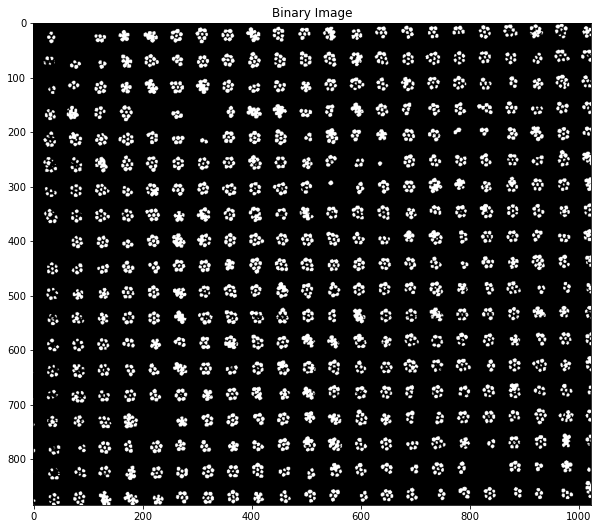

In [5]:
croppedBin = oiplib.gray2Binary(cropped)
oiplib.showImage(croppedBin, vmax=1, figsize=(10,10), title="Binary Image")

    2. Dilate the image using convolution

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6013970>)

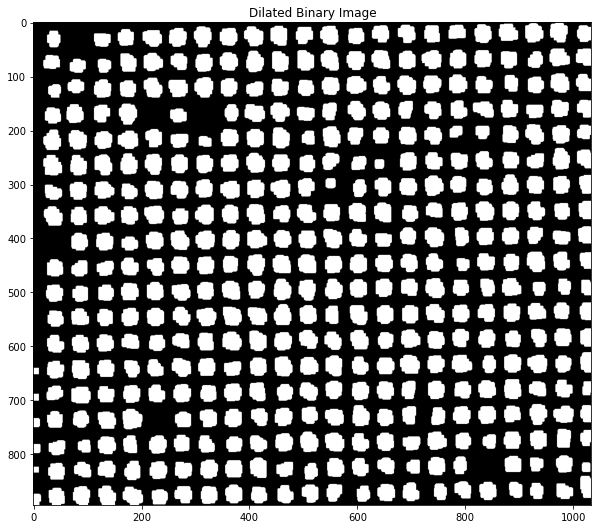

In [6]:
croppedBin = oiplib.growBinary(croppedBin, 11)
oiplib.showImage(croppedBin, vmax=1, figsize=(10,10), title="Dilated Binary Image")

    3. Label regions within the image using flood fill

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d3310b0>)

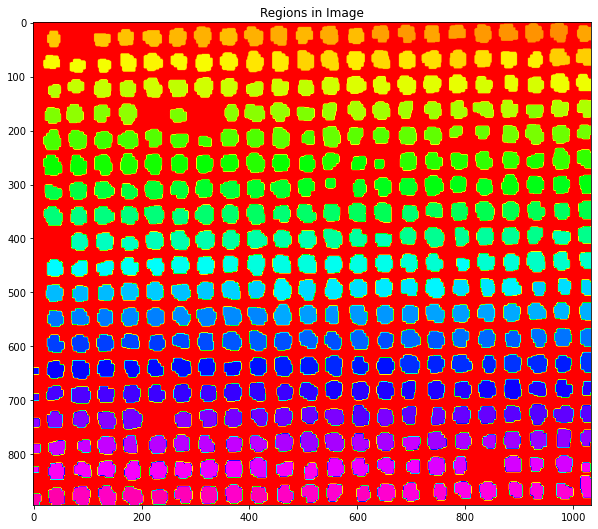

In [7]:
regionImg = oiplib.labelRegions(croppedBin, lmin=50)
oiplib.showImage(regionImg, figsize=(10,10), cmap="hsv", title="Regions in Image", vmax=oiplib.arrayMax(regionImg)+50)

    4. Get the boundary boxes for region

In [8]:
anchors, boxSize = oiplib.getBoundaryBoxes(regionImg)

    5. Using the boundary boxes, divide the image into clusters

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1de50ef0>)

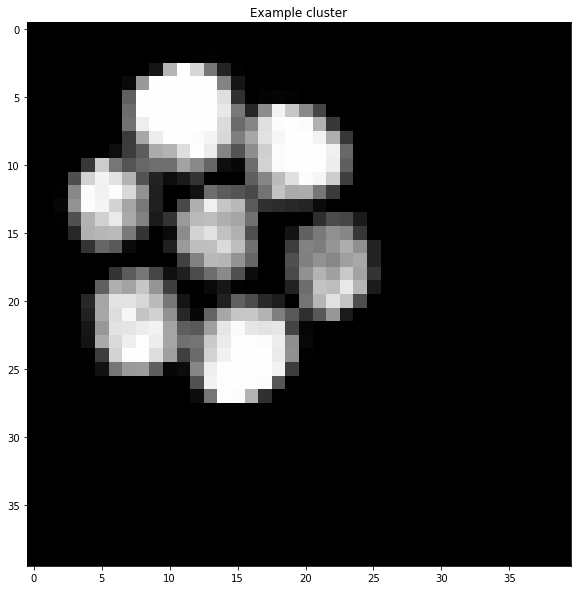

In [9]:
clusters = []

for anchor in anchors:
    x, y = anchor
    
    # Crop image and remove background noise
    clusters.append(oiplib.removeBackgroundNoise(cropped[x:x + boxSize, y:y + boxSize]))
    
oiplib.showImage(clusters[0], figsize=(10,10), title="Example cluster")

### 4. Find the number of beads in each cluster
For this step, we use the cluster images from step 3. The steps are performed for each cluster.
    1. Scale image to increase resolution
    2. Erode image to amplify features
    3. Create distance map for watershedding
    4. Perform the watershed algorithm
    5. Count the number of labels in cluster

In [10]:
beadCounts = {}

for cluster in clusters:
    labelImg = oiplib.labelRegionWatershed(cluster)
    labels = oiplib.unique(labelImg)
    
    beadCount = len(labels) - 1
    
    if beadCounts.get(beadCount) is None:
        beadCounts[beadCount] = 1
    else:
        beadCounts[beadCount] += 1

Create histogram of bead counts

<BarContainer object of 19 artists>

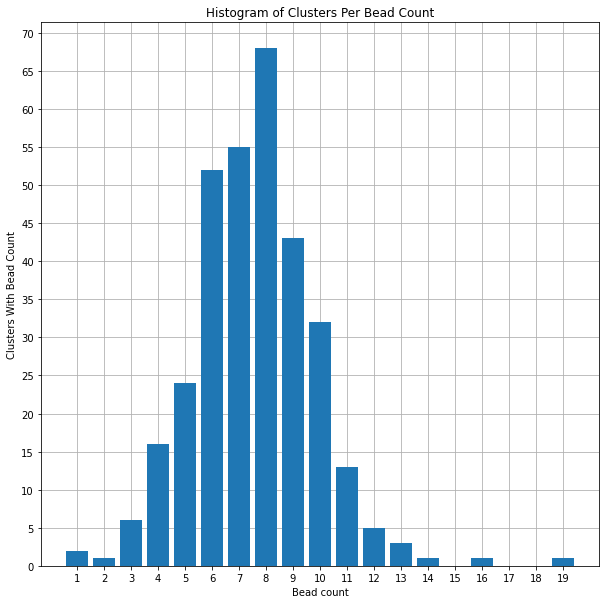

In [11]:
oiplib.beadCountHist(beadCounts)

We see that the bead count is centered around 7-8, which is to be expected.

### 5. Find the size of each bead in each cluster
For this step, we use the cluster images from step 3. The steps are performed for each cluster.

    1. Watershed the cluster using the same process as step 4.
    5. Using the area of each label, approximate a circle with the same area.
    6. Dilate circles to compensate for the erosion in step 5.2.
    7. Find area of dilated circles
    8. Use dilated areas to approximate new circles
    9. Find the diameters of these circles
    10. Convert the diameters from pixels to real world size using the value found in step 2.

In [12]:
sizes = []

for cluster in clusters:
    # Find beads
    
    labelImg = oiplib.labelRegionWatershed(cluster)
    beads, areas = oiplib.unique(labelImg, return_counts=True)
    
    # Approximate the diameter of each bead
    
    diameters = []
    
    for area in areas[1:]: # We skip the first element as it is the background
        diameters.append(oiplib.areaToDiameter(area))
        
    # Find the area of each bead, compensating for erosion
    
    compAreas = []
    
    for diameter in diameters: 
        compAreas.append(oiplib.dilateBead(diameter, labelImg.shape))
        
    # We approximate the diameters using the compensated areas
    
    diameters = []
    
    for area in compAreas:
        diameters.append(oiplib.areaToDiameter(area)/10) # We divide by 10, as we scaled the image up 10
        
    # Write the diameters to the global array, converting it to real world size in the process.
    #We floor the value so the data is arranged in bins with integer intervals
    
    for diameter in diameters:
        sizes.append(oiplib.pixelToLength(diameter, pixelSize * pow(10, 9)))

We create a dictionary to better organize the data.

In [13]:
sizes = oiplib.unique(oiplib.floor(sizes), return_counts=True)

sizesDict = dict()

for i in range(int(oiplib.arrayMax(sizes[1]))):
    sizesDict[i] = 0

for i, size in enumerate(sizes[0]):
    sizesDict[size] = sizes[1][i]

Create histogram of bead sizes

<BarContainer object of 157 artists>

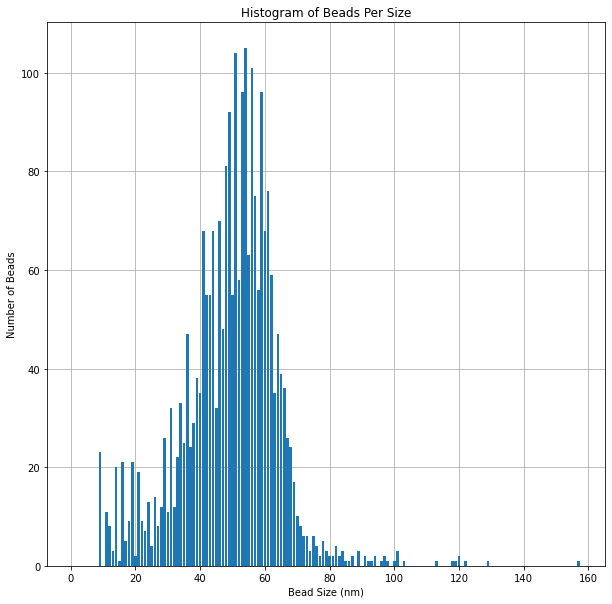

In [14]:
oiplib.beadSizeHist(sizesDict)

The bead sizes are collected mainly around the 50-60 nm area. This is a bit lower than the expected 60-70 range. This is likely due to the dilation and erosion steps performed when seperating the beads within the clusters. The outliers are from clusters that were not separated correctly.